# Autoencoder

## Setup

In [1]:
%load_ext autotime

In [2]:
# various
from math import ceil
from time import time
from tqdm import tqdm
import csv
import matplotlib.pylab as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
import os
import PIL
# sklearn
import sklearn
import sklearn.utils
import sklearn.metrics
import sklearn.datasets
import sklearn.decomposition
# pytorch
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import torchviz
# plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

time: 1.65 s


In [3]:
# setup a device; use CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda', 0)
else:
    device = torch.device('cpu')

device

device(type='cpu')

time: 6.37 ms


## Image compression with Autoencoder

In [4]:
# define the autoencoder
class ShallowAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, bias=False):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim, bias=bias)
        self.decoder = nn.Linear(hidden_dim, input_dim, bias=bias)
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

time: 29 ms


### Load image

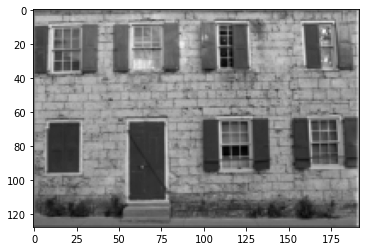

time: 348 ms


In [5]:
# load image
img = PIL.Image.open(os.path.join('..', 'data', 'kodim01.png'))
# convert to grayscale
img = img.convert('L')
# resize
img = img.resize((int(1.5*128), 128), resample=PIL.Image.BILINEAR)
# store as numpy array
img = np.array(img)
# fetch dimensions
H, W = img.shape
# show image
plt.imshow(img, cmap='gray')
plt.show()

### Train an Autoencoder

In [6]:
# hidden layer size
input_dim = W*H
hidden_dim = 20*20
# number of training epochs
n_epochs = 100

# initialize the model
model = ShallowAutoencoder(input_dim, hidden_dim).to(device)

# prepare the input
x = torch.Tensor(img).reshape(1, -1).to(device)

# train for some epochs
optim = torch.optim.Adam(model.parameters())
model.train() # set to training mode
trace = []
for _ in tqdm(range(n_epochs)):
    # setup
    optim.zero_grad()
    
    # fetch reconstructed image
    pred = model(x)
    
    # apply MSE
    loss = F.mse_loss(pred, x)
    
    # gradient descent step
    loss.backward()
    optim.step()
    
    # record loss
    trace.append(loss.item())

# set to testing mode for subsequent cells
_ = model.eval()

100%|██████████| 100/100 [00:23<00:00,  4.32it/s]

time: 23.3 s


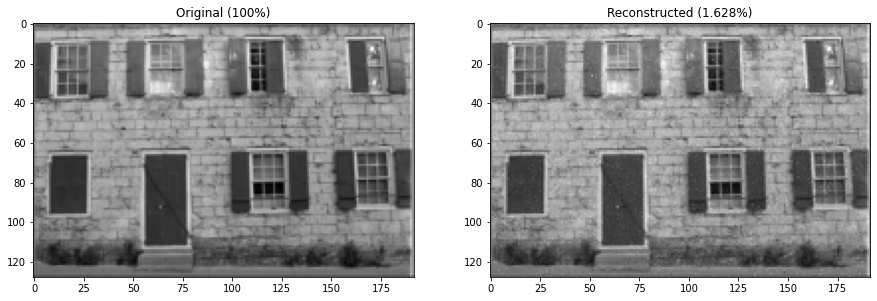

time: 392 ms


In [7]:
# get the reconstructed image
rec = model(x).reshape(H, W).cpu().detach().numpy()

# compute the compressed size
csize = 100.0 * hidden_dim / (W*H)

# show image comparison
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
# show the original
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original (100%)')
# show the reconstructed image
ax[1].imshow(rec, cmap='gray')
ax[1].set_title('Reconstructed ({:0.3f}%)'.format(csize))

plt.show()

### Is this approach practical?

In [8]:
# prepare the input
x = torch.Tensor(img).reshape(1, -1).to(device)

# initialize the model
model = ShallowAutoencoder(
    input_dim=W*H,
    hidden_dim=1,
    bias=True).to(device)

time: 3.25 ms


In [9]:
# train the model
model.decoder.weight.data = torch.Tensor(img).reshape(-1, 1).to(device)
model.encoder.weight.data = torch.zeros((1, W*H)).to(device)
model.encoder.bias.data = torch.ones((1, 1)).to(device)

# The approach is not practical since there's only one sample.
# We cannot generalize (learn) from a single sample.
# The network can just copy the input - which is done manually above - and get a perfect reconstruction!
# The reason this hasn't happened before is due to stochastic training (SGD) and local minima.

time: 3.92 ms


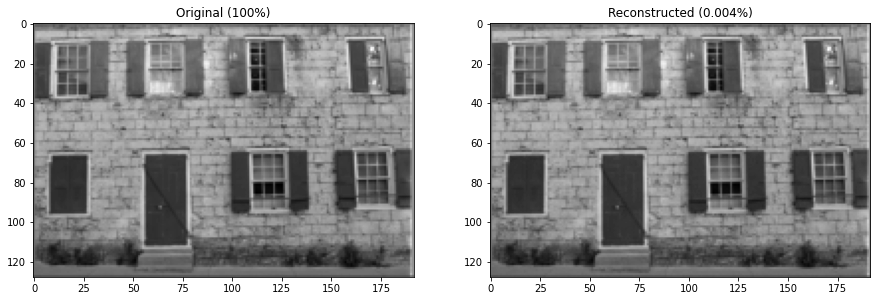

time: 417 ms


In [10]:
# get the reconstructed image
rec = model(x).reshape(H, W).cpu().detach().numpy()

# compute the compressed size
csize = 100.0 * 1 / (W*H) 

# show image comparison
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
# show the original
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original (100%)')
# show the reconstructed image
ax[1].imshow(rec, cmap='gray')
ax[1].set_title('Reconstructed ({:0.3f}%)'.format(csize))

plt.show()

## Image classification

### Load dataset

In [11]:
# load mnist dataset
with open(os.path.join('..', 'data', 'mnist', 'mnist_train.csv'), 'r') as ifile:
    data = np.array([[int(cell) for cell in row] for row in csv.reader(ifile)])
    Y_train, X_train = data[:, 0], data[:, 1:]
with open(os.path.join('..', 'data', 'mnist', 'mnist_test.csv'), 'r') as ifile:
    data = np.array([[int(cell) for cell in row] for row in csv.reader(ifile)])
    Y_test, X_test = data[:, 0], data[:, 1:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

time: 16.1 s


In [12]:
# Alternative: fashion-mnist dataset
# load fashion-mnist dataset
#with open(os.path.join('..', 'data', 'fmnist', 'fashion_mnist_train.csv'), 'r') as ifile:
#    data = np.array([[int(cell) for cell in row] for row in csv.reader(ifile)])
#    Y_train, X_train = data[:, 0], data[:, 1:]
#with open(os.path.join('..', 'data', 'fmnist', 'fashion_mnist_test.csv'), 'r') as ifile:
#    data = np.array([[int(cell) for cell in row] for row in csv.reader(ifile)])
#    Y_test, X_test = data[:, 0], data[:, 1:]
#
#X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

time: 508 µs


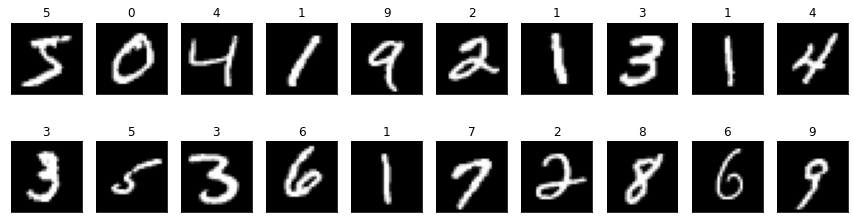

time: 715 ms


In [13]:
# show example images
rows, cols = 2, 10
fig, ax = plt.subplots(rows, cols)
fig.set_size_inches(15, 4)
for cax, ex, lbl in zip(ax.reshape(-1), X_train, Y_train):
    cax.imshow(ex.reshape(28, 28), cmap='gray')
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_title(lbl)
plt.show()

### Baseline: Nearest-Neighbour classifier in the image space

NN: We assign a testing sample the label of its closest training sample.

In [14]:
pred_bs = [] # store predictions per testing sample

# start the clock
t_baseline = time()

# classify all testing data samples
for batch in sklearn.utils.gen_batches(len(X_test), 100):
    # fetch test batch
    X_batch = X_test[batch]
    Y_batch = Y_test[batch]
    
    # classify in data space w.r.t. training samples
    # uses the euclidean distance
    dist = sklearn.metrics.pairwise_distances(X_batch, X_train)
    
    # find nearest neighbour's label
    nearest_neighbours = Y_train[dist.argmin(axis=1)]
    
    # store predictions
    pred_bs.append(nearest_neighbours)

# stop the clock
t_baseline = time() - t_baseline

# collect predictions in one array
pred_bs = np.hstack(pred_bs)

time: 54.5 s


In [15]:
# accuracy in %
100 * sklearn.metrics.accuracy_score(Y_test, pred_bs)

96.91

time: 4.77 ms


### Autoencoder for MNIST images

In [16]:
# initialize and train the autoencoder

input_dim = X_train.shape[1] # define number of input features
hidden_dim = 40 # define the number of latent features
n_epochs = 1_000 # set the number of training epochs
n_epochs = 0 # skip training since we're loading a pre-trained model later on

# initialize the model
model = ShallowAutoencoder(input_dim, hidden_dim).to(device)

# prepare the input
x = torch.Tensor(X_train).to(device)

# train for some epochs
optim = torch.optim.Adam(model.parameters())
model.train() # set to training mode
trace = []
for _ in tqdm(range(n_epochs)):
    # setup
    optim.zero_grad()
    
    # fetch reconstructed image
    pred = model(x)
    
    # apply MSE
    loss = F.mse_loss(pred, x)
    
    # gradient descent step
    loss.backward()
    optim.step()
    
    # record loss
    trace.append(loss.item())

# save the model
#torch.save(model, 'ae_mnist.pt')

# set to testing mode for subsequent cells
_ = model.eval()

0it [00:00, ?it/s]

time: 90.1 ms


In [17]:
# load pre-trained model since training takes a while on a CPU
if os.path.exists('ae_mnist.pt'):
    model = torch.load('ae_mnist.pt', map_location=device)

time: 1.75 ms


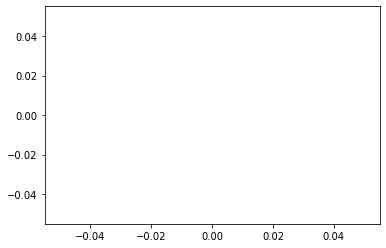

time: 190 ms


In [18]:
# show the development of the loss during training
plt.plot(trace)
plt.show()

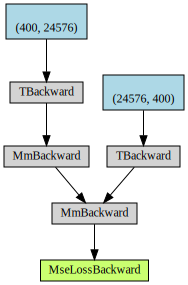

time: 92 ms


In [19]:
# show a visualization of the autoencoder model
torchviz.make_dot(loss)

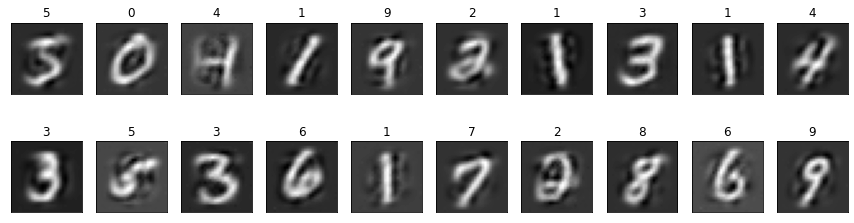

time: 987 ms


In [20]:
# show reconstructed images
rows, cols = 2, 10
fig, axes = plt.subplots(rows, cols)
fig.set_size_inches(15, 4)

# plot reconstructed image
for ax, sample, label in zip(axes.reshape(-1), X_train, Y_train):
    # prepare the sample
    sample = torch.Tensor(sample).to(device)
    sample = sample.reshape(1, -1)
    # pass the images through the 
    reconstructed = model(sample)
    reconstructed = reconstructed.detach().cpu().numpy()
    # show reconstructed sample as image
    ax.imshow(reconstructed.reshape(28, 28), cmap='gray')
    # some style
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(label)

plt.show()

### Nearest-Neighbour classifier in the latent space

The nearest neighbour classification works in the same way as for the baseline, however now the comparison is performed in the latent space (i.e. output of the encoder).

In [21]:
pred_ae = [] # store predictions per testing sample

# start the clock
t_ae = time()

# neighbour references from training set
base = model.encoder(torch.Tensor(X_train).to(device))

# predict classes of samples in the testing set
for batch in sklearn.utils.gen_batches(len(X_test), 100):
    # fetch test batch
    X_batch = torch.Tensor(X_test[batch]).to(device)
    Y_batch = Y_test[batch]
    
    # project to latent space
    hidden = model.encoder(X_batch)
    
    # classify in latent space w.r.t. training samples
    dist = torch.cdist(hidden, base, p=2)
    
    # find nearest neighbour
    nearest_neighbours = Y_train[dist.argmin(dim=1).cpu().detach().numpy()]
    
    # store predictions
    pred_ae.append(nearest_neighbours)

# stop the clock
t_ae = time() - t_ae

# collect predictions in one array
pred_ae = np.hstack(pred_ae)

time: 3.49 s


In [22]:
# accuracy in %
100 * sklearn.metrics.accuracy_score(Y_test, pred_ae)

97.31

time: 5.07 ms


### Comparison: Autoencoder vs. Baseline

In [23]:
# accuracy
print('Baseline   : {:0.3f}%'.format(100 * sklearn.metrics.accuracy_score(Y_test, pred_bs)))
print('Autoencoder: {:0.3f}%'.format(100 * sklearn.metrics.accuracy_score(Y_test, pred_ae)))
print()

Baseline   : 96.910%
Autoencoder: 97.310%

time: 4.29 ms


In [24]:
# time (classification time only)
print('Baseline   : {:0.3f}s'.format(t_baseline))
print('Autoencoder: {:0.3f}s'.format(t_ae))
print()

Baseline   : 54.502s
Autoencoder: 3.491s

time: 781 µs


In [25]:
# space
print('BS Image: 100%')
print('AE Image: {:0.3f}%'.format(100 * hidden_dim / X_train.shape[1]))
print()

print('BS training data: 100%')
print('AE training data: {:0.3f}%'.format(
    # encoder size + decoder size + compressed images
    (2 * input_dim * hidden_dim + X_train.shape[0] * hidden_dim) / \
    # training dataset size
    (X_train.shape[0] * X_train.shape[1])))
print()

BS Image: 100%
AE Image: 5.102%

BS training data: 100%
AE training data: 0.052%

time: 8.2 ms


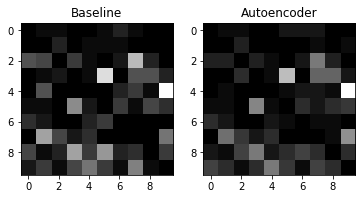

time: 284 ms


In [26]:
# misclassifications (w/o TP). read as: x=9, y=4: Number of true "4" predicted as "9"
fig, ax = plt.subplots(1, 2)
mask = (np.ones((10,10)) - np.eye(10,10))
ax[0].imshow(sklearn.metrics.confusion_matrix(Y_test, pred_bs) * mask, cmap='gray')
ax[0].set_title('Baseline')
ax[1].imshow(sklearn.metrics.confusion_matrix(Y_test, pred_ae) * mask, cmap='gray')
ax[1].set_title('Autoencoder')

plt.show()

# Non-linear data

### Generate example data

In [27]:
# generate some non-linear data (swiss roll)
X_roll, Y_roll = sklearn.datasets.make_swiss_roll(n_samples=10_000, noise=0.1)
# normalize the data
X_roll = sklearn.preprocessing.MinMaxScaler().fit_transform(X_roll)

X_roll.shape

(10000, 3)

time: 9.1 ms


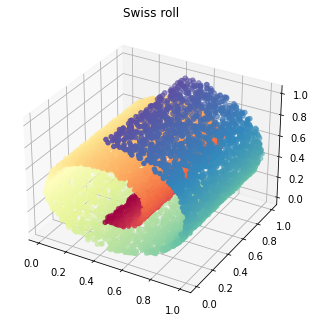

time: 365 ms


In [28]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.scatter(X_roll[:,0], X_roll[:,1], X_roll[:,2], c=Y_roll, cmap=plt.cm.Spectral)
plt.title('Swiss roll')
plt.show()

### PCA on nonlinear data

In [29]:
# initialize the model
pca = sklearn.decomposition.PCA(n_components=2)

# train the model
pca.fit(X_roll)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

time: 46.9 ms


In [30]:
# reprojection error
loss_pca = sklearn.metrics.mean_squared_error(X_roll, pca.inverse_transform(pca.transform(X_roll)))
loss_pca

0.023349175476458175

time: 17.3 ms


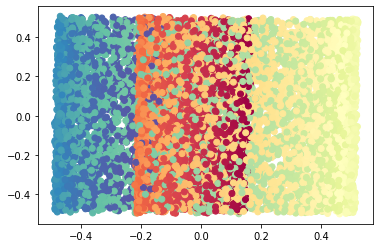

time: 423 ms


In [31]:
# compress the roll via PCA
comp = pca.transform(X_roll)

# plot the 2D space
plt.scatter(comp[:, 0], comp[:, 1], c=Y_roll, cmap=plt.cm.Spectral)
plt.show()

In [32]:
# reproject from PCA to 3D
rep_pca = pca.inverse_transform(comp)

# plot
iplot(dict(data=[
    go.Scatter3d(
        x=rep_pca[:, 0],
        y=rep_pca[:, 1],
        z=rep_pca[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=Y_roll,
        ),
    )
]))

time: 666 ms


### Shallow and linear Autoencoder

In [33]:
# initialize and train the autoencoder
n_epochs = 1_000 # set the number of training epochs

# initialize the model
shallow_ae = ShallowAutoencoder(3, 2).to(device)

# prepare the input
x = torch.Tensor(X_roll).to(device)

# train for some epochs
optim = torch.optim.Adam(shallow_ae.parameters())
shallow_ae.train() # set to training mode
trace = []
for _ in tqdm(range(n_epochs)):
    # setup
    optim.zero_grad()
    
    # fetch reconstructed image
    pred = shallow_ae(x)
    
    # apply MSE
    loss = F.mse_loss(pred, x)
    
    # gradient descent step
    loss.backward()
    optim.step()
    
    # record loss
    trace.append(loss.item())

# set to testing mode for subsequent cells
_ = shallow_ae.eval()

100%|██████████| 1000/1000 [00:01<00:00, 870.15it/s]

time: 1.15 s


In [34]:
# reprojection error
loss_shallow = F.mse_loss(x, shallow_ae(x)).item()
loss_shallow

0.02682916820049286

time: 4.4 ms


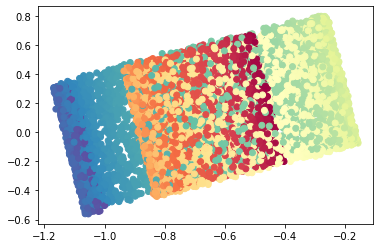

time: 487 ms


In [35]:
# compress the roll via a shallow Autoencoder
comp = shallow_ae.encoder(x)
comp = comp.cpu().detach().numpy()
# plot
plt.scatter(comp[:, 0], comp[:, 1], c=Y_roll, cmap=plt.cm.Spectral)
plt.show()

In [36]:
# compress and reconstruct the roll via shallow Autoencoder
rep_shallow = shallow_ae(x)
rep_shallow = rep_shallow.detach().cpu().numpy()

# plot
iplot(dict(data=[
    go.Scatter3d(
        x=rep_shallow[:, 0],
        y=rep_shallow[:, 1],
        z=rep_shallow[:, 2],
        mode='markers',
        marker=dict(size=4, color=Y_roll),
    )]))

time: 424 ms


### Autoencoder with nonlinearity

In [37]:
class DeepAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(3),
            nn.Linear(3, 16, bias=False),
            nn.ReLU(),
            nn.Linear(16, 32, bias=False),
            nn.Sigmoid(),
            nn.Linear(32, 16, bias=False),
            nn.ReLU(),
            nn.Linear(16, 2, bias=False),
        )
        self.decoder = nn.Sequential(
            nn.BatchNorm1d(2),
            nn.Linear(2, 16, bias=False),
            nn.ReLU(),
            nn.Linear(16, 32, bias=False),
            nn.Sigmoid(),
            nn.Linear(32, 16, bias=False),
            nn.ReLU(),
            nn.Linear(16, 3, bias=False),
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

time: 3.04 ms


In [38]:
# initialize and train the autoencoder
n_epochs = 40_000 # set the number of training epochs
n_epochs = 0 # skip training since we're loading a pre-trained model later on

# initialize the model
deep_ae = DeepAutoencoder().to(device)

# prepare the input
x = torch.Tensor(X_roll).to(device)

# train for some epochs
optim = torch.optim.Adam(deep_ae.parameters(), lr=0.01)
deep_ae.train() # set to training mode
trace = []
for _ in tqdm(range(n_epochs)):
    # setup
    optim.zero_grad()
    
    # fetch reconstructed image
    pred = deep_ae(x)
    
    # apply MSE
    loss = F.mse_loss(pred, x)
    
    # gradient descent step
    loss.backward()
    optim.step()
    
    # record loss
    trace.append(loss.item())

# save the model
#torch.save(model, 'ae_roll.pt')

# set to testing mode for subsequent cells
_ = deep_ae.eval()

0it [00:00, ?it/s]

time: 14.2 ms


In [39]:
# load pre-trained deep Autoencoder since training takes a while
# NOTE: the DeepAutoencoder easily gets stuck in local minima.
# Finding a good model might take a couple of tries.
if os.path.exists('ae_roll.pt'):
    deep_ae = torch.load('ae_roll.pt', map_location=device)

time: 3.52 ms


In [40]:
# reprojection error
loss_deep = F.mse_loss(deep_ae(x), x).item()
loss_deep

0.0002678454911801964

time: 11.7 ms


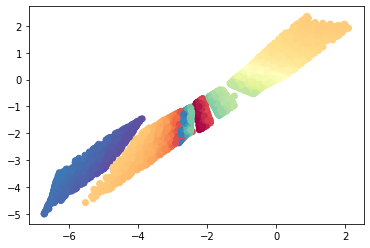

time: 479 ms


In [41]:
# compress the roll via a shallow Autoencoder
comp = deep_ae.encoder(x)
comp = comp.cpu().detach().numpy()
# plot
plt.scatter(comp[:, 0], comp[:, 1], c=Y_roll, cmap=plt.cm.Spectral)
plt.show()

In [42]:
# compress and reconstruct the roll via shallow Autoencoder
rep_deep = deep_ae(x)
rep_deep = rep_deep.detach().cpu().numpy()

# plot
iplot(dict(data=[
    go.Scatter3d(
        x=rep_deep[:, 0],
        y=rep_deep[:, 1],
        z=rep_deep[:, 2],
        mode='markers',
        marker=dict(size=4, color=Y_roll),
    )]))

time: 405 ms


### Comparison

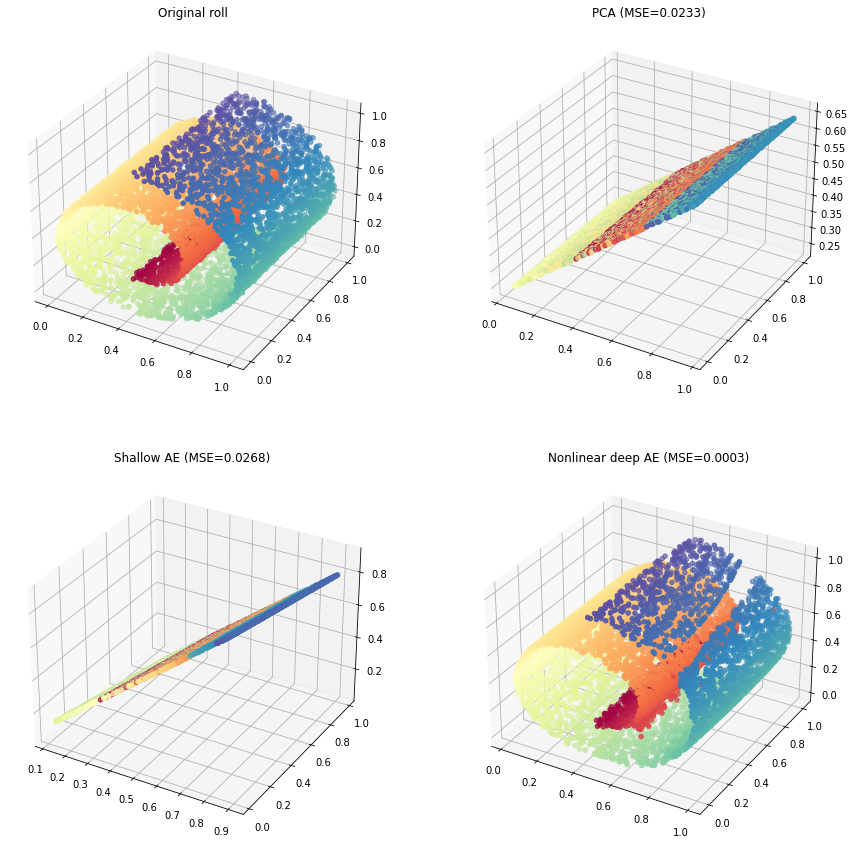

time: 1.45 s


In [43]:
fig = plt.figure(figsize=plt.figaspect(0.5))
fig.set_size_inches(15, 15)

# show the original roll
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(X_roll[:,0], X_roll[:,1], X_roll[:,2], c=Y_roll, cmap=plt.cm.Spectral)
ax.set_title('Original roll')

# show the reconstruction via PCA
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(rep_pca[:,0], rep_pca[:,1], rep_pca[:,2], c=Y_roll, cmap=plt.cm.Spectral)
ax.set_title(f'PCA (MSE={loss_pca:0.4f})')

# show the reconstruction via shallow Autoencoder
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.scatter(rep_shallow[:,0], rep_shallow[:,1], rep_shallow[:,2], c=Y_roll, cmap=plt.cm.Spectral)
ax.set_title(f'Shallow AE (MSE={loss_shallow:0.4f})')

# show the reconstruction via nonlinear deep Autoencoder
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter(rep_deep[:,0], rep_deep[:,1], rep_deep[:,2], c=Y_roll, cmap=plt.cm.Spectral)
ax.set_title(f'Nonlinear deep AE (MSE={loss_deep:0.4f})')

plt.show()